# Pipeline for High-z Radio Galaxies 12: Application of full pipeline for prediction

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd
import mpl_scatter_density
# import schemdraw
# from schemdraw import flow

In [2]:
mpl.rcdefaults()

Create path effects.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    try:
        med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    except:
        med = np.nanmedian(np.abs(z_true - z_pred))
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    try:
        med  = np.nanmedian(np.abs(frac)).astype('float32')
    except:
        med  = np.nanmedian(np.abs(frac))
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    try:
        rot = np.sqrt(ssq / len(z_true)).astype('float32')
    except:
        rot = np.sqrt(ssq / len(z_true))
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    try:
        rot = np.sqrt(ssq / len(z_true)).astype('float32')
    except:
        rot = np.sqrt(ssq / len(z_true))
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    try:
        siz  = np.sum(np.isfinite(dif)).astype('float32')
        num  = np.sum(np.array(dif > 0.15)).astype('float32')
    except:
        siz  = np.sum(np.isfinite(dif))
        num  = np.sum(np.array(dif > 0.15))
    frac = num / siz
    return frac

Methods for Pycaret and saved models.

In [9]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [10]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

Methods for the use of values in Confusion Matrices.

In [11]:
def flatten_CM(cm_array):
    try:
        TN, FP, FN, TP = cm_array.flatten().astype('float32')
    except:
        TN, FP, FN, TP = cm_array.flatten()
    return TN, FP, FN, TP

In [12]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = flatten_CM(cm_array)
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [13]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = flatten_CM(cm_array)
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [14]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = flatten_CM(cm_array)
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [15]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = flatten_CM(cm_array)
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [16]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(stretch=PowerStretch(0.35))

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal', values_format=',')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(28)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=16)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [17]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.5))

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

Functions to predict values

In [18]:
def predict_star(catalog_df, star_model, threshold, raw_score=True):
    catalog_df = pyc.predict_model(star_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_1'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    catalog_df.loc[:, 'Score_no_star'] = np.around(catalog_df.loc[:, 'Score_no_star'], decimals=7)
    return catalog_df

In [19]:
def predict_AGN_gal(catalog_df, AGN_gal_model, threshold, raw_score=True):
    catalog_df = pyc.predict_model(AGN_gal_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
    catalog_df.loc[:, 'Score_AGN'] = np.around(catalog_df.loc[:, 'Score_AGN'], decimals=7)
    return catalog_df

In [20]:
def predict_radio_det(catalog_df, radio_model, threshold, raw_score=True):
    catalog_df = pyc.predict_model(radio_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
    catalog_df.loc[:, 'Score_radio'] = np.around(catalog_df.loc[:, 'Score_radio'], decimals=7)
    return catalog_df

In [21]:
def predict_z_full(catalog_df, redshift_model):
    catalog_df = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    catalog_df = catalog_df.rename(columns={'Label': 'pred_Z'})
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [22]:
def predict_z_high(catalog_df, redshift_model, z_lim, z_tol):
    catalog_df    = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    filter_pred_z = catalog_df.loc[:, 'pred_Z'] >= (z_lim + z_tol)
    catalog_df.loc[:, 'pred_Z'] = catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, catalog_df.loc[filter_pred_z, 'Label'])
    catalog_df    = catalog_df.drop(columns=['Label'])
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [23]:
def add_AGN_criteria(catalog_df):
    catalog_df['M12_AGN'] = M12_AGN_criterion(catalog_df)
    catalog_df['S12_AGN'] = S12_AGN_criterion(catalog_df)
    catalog_df['M16_AGN'] = M16_AGN_criterion(catalog_df)
    catalog_df['B18_AGN'] = B18_AGN_criterion(catalog_df)
    return catalog_df

In [24]:
def M12_AGN_criterion(catalog_df):
    M12_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 <
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 0.791) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 0.222) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           -3.172 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 7.624)).astype(int)
    return M12_column

In [25]:
def S12_AGN_criterion(catalog_df):
    S12_column = np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >= 0.8).astype(int)
    return S12_column

In [26]:
def M16_AGN_criterion(catalog_df):
    M16_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 < 4.4)).astype(int)
    return M16_column

In [27]:
def B18_AGN_criterion(catalog_df):
    B18_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 > 2.2) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           2 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 8.9)).astype(int)
    return B18_column

---

## Reading data

In [28]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Flags.

In [29]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False  # z >= 2.0
use_third_z_model   = False  # z >= 3.0
use_fourth_z_model  = True  # z >= 3.7 (with SMOGN), or, if needed, z >= 4.0
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [30]:
used_area           = 'COSMOS'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Validation'  # Validation, Training, Test, Test+Train

In [31]:
if used_area != 'S82':
    compare_A17_flag = False

In [32]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_S82_Ananna_17  = f'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_Ananna_17_zsp_5sigma_imp.h5'  # 204 objects

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [33]:
# feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
# feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
# feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc_S82    = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [34]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [35]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [36]:
if use_zeroth_model:
    full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)
elif not use_zeroth_model:
    full_catalog_df['is_str'] = np.zeros_like(full_catalog_df.loc[:, 'spCl'])

In [37]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [38]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

##### Random seed

In [39]:
seed                                = 42

---

Split dataset if from HETDEX

In [40]:
if used_area == 'HETDEX':
    if use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
            (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
    elif not use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
    unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
    full_catalog_df   = full_catalog_df.loc[filter_known_spec]
    train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                        random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
    train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                        random_state=seed, stratify=train_test_df.loc[:, 'class'])
    print('Shape of used data in HETDEX')
    print('(Confirmed galaxies and AGN)')
    print('-' * 50)
    print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
    print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
    print(f'Training data:                      {train_df.shape}')
    print(f'Testing data:                       {test_df.shape}')
    print(f'Unseen Data For Validation:         {validation_df.shape}')
    print('-' * 50)
    print()
    print(f'Using {HETDEX_subset} data from HETDEX')
    selected_dataset = {'Training': train_df, 'Test': test_df, 'Test+Train': train_test_df,\
                        'Validation': validation_df}
    full_catalog_df = selected_dataset[HETDEX_subset]

Split data if not from HETDEX

In [41]:
if used_area != 'HETDEX':
    filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                       (full_catalog_df.loc[:, 'class'] == 1) |\
                       (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
    unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
    full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [42]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (1502, 57)
--------------------------------------------------
Thus, it has 1,502 sources and 57 features.


Discard minor features.

In [43]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])

---

### Load models

In [44]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model('models/classification_star_no_star_jun_30_2022')  # star/no-star model
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_16_2022')
    redshift_reg    = pyr.load_model('models/regression_z_may_17_2022')  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model('models/regression_z_may_18_2022')  # to use on sources with predicted z >= 2
    if use_third_z_model:
        redshift_reg_3  = pyr.load_model('models/regression_z_may_30_2022')  # to use on sources with predicted z >= 3
    if use_fourth_z_model:
        # redshift_reg_4  = pyr.load_model('models/regression_z_may_31_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        # redshift_reg_4  = pyr.load_model('models/regression_z_may_31_4_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        # redshift_reg_4  = pyr.load_model('models/regression_z_jun_01_2022')  # to use on sources with predicted z >= 3.7 used with SMOGN
        redshift_reg_4  = pyr.load_model('models/regression_z_jul_19_2022')  # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [45]:
if use_zeroth_model:
    threshold_star = 0.37441  # 0.5, 0.15688 from ROC AUC in train+test, 0.37441 from PR curve
threshold_AGN   = 0.31117  # 0.5, 0.3094 from ROC AUC in train+test, 0.31117 from PR curve
threshold_radio = 4.99972232e-01  # 0.5, 4.99972232e-01 from ROC AUC in train+test and PR curve

In [46]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = predict_star(full_catalog_df, star_clf, threshold_star)
    unknown_cat_df  = predict_star(unknown_cat_df,  star_clf, threshold_star)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1
    unknown_cat_df['pred_star']      = 0
    unknown_cat_df['Score_no_star']  = 1

In [47]:
full_catalog_df = predict_AGN_gal(full_catalog_df, AGN_gal_clf, threshold_AGN)
unknown_cat_df  = predict_AGN_gal(unknown_cat_df,  AGN_gal_clf, threshold_AGN)

In [48]:
full_catalog_df = predict_radio_det(full_catalog_df, radio_det_clf, threshold_radio)
unknown_cat_df  = predict_radio_det(unknown_cat_df,  radio_det_clf, threshold_radio)

In [49]:
full_catalog_df = predict_z_full(full_catalog_df, redshift_reg)
unknown_cat_df  = predict_z_full(unknown_cat_df,  redshift_reg)

Scores before applying further z models

In [50]:
if use_zeroth_model:
    temp_filt_pred_nstr    = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN        = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio'] == 1) &\
                             temp_filt_pred_nstr
sigma_mad_early            = sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_nmad_early           = sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_early              = sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_norm_early         = sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
out_frac_early             = outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])

In [51]:
temp_z_limit               = 3.6
temp_filt_high_z_rAGN      = temp_filt_pred_rAGN * (full_catalog_df.loc[:, 'pred_Z'] >= temp_z_limit)
sigma_mad_early_hiz        = sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_nmad_early_hiz       = sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_early_hiz          = sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_norm_early_hiz     = sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
out_frac_early_hiz         = outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])

In [52]:
redshift_lim_a    = 2.0
redshift_tol_a    = 0.0
redshift_lim_b    = 3.0
redshift_tol_b    = 0.0
redshift_lim_c    = 3.6  # 3.6, 3.7, 4.0
redshift_tol_c    = 0.0
if use_second_z_model:
    full_catalog_df = predict_z_high(full_catalog_df, redshift_reg_2, redshift_lim_a, redshift_tol_a)
    unknown_cat_df  = predict_z_high(unknown_cat_df,  redshift_reg_2, redshift_lim_a, redshift_tol_a)
if use_third_z_model:
    full_catalog_df = predict_z_high(full_catalog_df, redshift_reg_3, redshift_lim_b, redshift_tol_b)
    unknown_cat_df  = predict_z_high(unknown_cat_df,  redshift_reg_3, redshift_lim_b, redshift_tol_b)
if use_fourth_z_model:
    full_catalog_df = predict_z_high(full_catalog_df, redshift_reg_4, redshift_lim_c, redshift_tol_c)
    unknown_cat_df  = predict_z_high(unknown_cat_df,  redshift_reg_4, redshift_lim_c, redshift_tol_c)

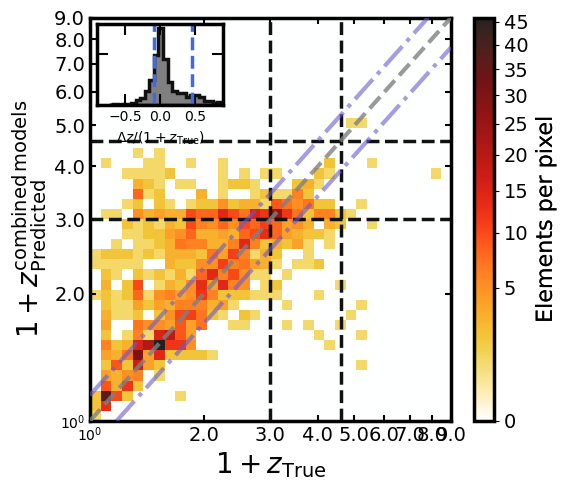

In [53]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axvline(x=(1 + redshift_lim_c), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_c), ls='--', c='k', lw=2.5)
if use_second_z_model or use_third_z_model or use_fourth_z_model:
    ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

Plot histogram to compare redshift predictions in after all models passings (on HETDEX validation data only).

In [54]:
if used_area == 'HETDEX':
    if HETDEX_subset == 'Full':
        filter_rAGN_t_H   = (full_catalog_df.loc[:, 'radio_AGN'] == 1)
        filter_redshift_H = (full_catalog_df.loc[:, 'Z'] > 0)
        full_catalog_H_df = full_catalog_df.loc[filter_rAGN_t_H & filter_redshift_H]
        
        train_test_H_df   = full_catalog_H_df.loc[np.isfinite(full_catalog_H_df.loc[:, 'Z'])].sample(frac=0.8, random_state=seed)  # Train + test sets
        validation_H_df   = full_catalog_H_df.drop(train_test_H_df.index)  # Validation data
        
        filter_rAGN_t_v_H = (full_catalog_df.loc[:, 'radio_AGN'] == 1)
        filt_rAGN_p_H     = (validation_H_df.loc[:, 'pred_class'] == 1) & (validation_H_df.loc[:, 'pred_radio'] == 1)
        filt_new_rAGN_p_H = filt_rAGN_p_H & np.array(validation_H_df.loc[:, 'radio_AGN'] == 0)

In [55]:
if used_area == 'HETDEX':
    if HETDEX_subset == 'Full':
        fig             = plt.figure(figsize=(10,3.5))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='log')
        
        min_for_range = np.nanmin([np.nanmin(validation_H_df.loc[:, 'Z']),\
                                   np.nanmin(validation_H_df.loc[:, 'pred_Z'])])
        max_for_range = np.nanmax([np.nanmax(validation_H_df.loc[:, 'Z']),\
                                   np.nanmax(validation_H_df.loc[:, 'pred_Z'])])
        bins_z        = np.linspace(min_for_range, max_for_range, 70)
        
        
        
        _, bins, _ = ax1.hist(validation_H_df.loc[:, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                              ec='k', fc='mediumpurple', lw=3.5,\
                              label=f"Predicted\nN={np.sum(np.isfinite(validation_H_df.loc[:, 'pred_Z'])):,}")
        ax1.hist(validation_H_df.loc[:, 'Z'], bins=bins_z, histtype='stepfilled', ec='k',\
                 fc='darkcyan', lw=3.5, label=f"True\nN={np.sum(np.sum(np.isfinite(validation_H_df.loc[:, 'Z']))):,}", alpha=0.7)
        
        # ax1.axvline(x=3.7, ls='--', c='k', lw=2.5, zorder=10)
        # ax1.axvline(x=3.8, ls='--', c='k', lw=2.5, zorder=10)
        # ax1.axvline(x=3.9, ls='--', c='k', lw=2.5, zorder=10)
        
        ax1.tick_params(which='both', top=True, right=True, direction='in')
        ax1.tick_params(axis='both', which='major', labelsize=14)
        ax1.tick_params(which='major', length=8, width=1.5)
        ax1.tick_params(which='minor', length=4, width=1.5)
        # ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
        ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
        ax1.set_ylabel('Frequency', size=20)
        # ax1.set_ylabel('Frequency', size=20)
        plt.setp(ax1.spines.values(), linewidth=3.5)
        plt.setp(ax1.spines.values(), linewidth=3.5)
        plt.legend(loc=1, fontsize=16)
        # ax1.invert_xaxis()
        # ax1.set_xlim(left=-4, right=6)
        #ax1.set_aspect('equal', 'box')
        ax1.set_title(used_area, fontsize=14)
        fig.tight_layout()
        if save_plot_flag:
            plt.savefig(f'plots/hist_true_predicted_z_{used_area}_validation.pdf')
        plt.show()

Additional columns with radio AGN prediction as a whole.

In [56]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_no_star'] *\
                                        full_catalog_df.loc[:, 'Score_AGN'] *\
                                        full_catalog_df.loc[:, 'Score_radio']
rad_score_scaler                      = MinMaxScaler()
rad_score_scaler.fit(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_radio'] = rad_score_scaler.transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [57]:
unknown_cat_df['pred_radio_AGN']     = np.array(unknown_cat_df.loc[:, 'pred_star']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
unknown_cat_df['Score_rAGN']         = unknown_cat_df.loc[:, 'Score_no_star'] *\
                                       unknown_cat_df.loc[:, 'Score_AGN'] *\
                                       unknown_cat_df.loc[:, 'Score_radio']

unknown_cat_df['scaled_score_radio'] = rad_score_scaler.transform(unknown_cat_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
unknown_cat_df['scaled_score_rAGN']  = unknown_cat_df.loc[:, 'Score_AGN'] * unknown_cat_df.loc[:, 'scaled_score_radio']

In [58]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
full_catalog_df.loc[:, displayed_cols].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,1502.000000,1502.000000,1502.000000,1502.000000,1413.000000,1502.000000
mean,0.779627,0.631158,0.475366,0.468708,1.072018,1.283274
std,0.414636,0.482652,0.499559,0.499186,0.827538,0.735958
min,0.000000,0.000000,0.000000,0.000000,0.006230,0.051400
25%,1.000000,0.000000,0.000000,0.000000,0.431850,0.583275
50%,1.000000,1.000000,0.000000,0.000000,0.878000,1.218400
75%,1.000000,1.000000,1.000000,1.000000,1.529000,1.892200
max,1.000000,1.000000,1.000000,1.000000,7.149000,4.017500


##### Include AGN detection criteria from literature

In [59]:
full_catalog_df = add_AGN_criteria(full_catalog_df)
unknown_cat_df  = add_AGN_criteria(unknown_cat_df)

Obtain intermediate metrics

In [60]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
if use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1) |\
                        (full_catalog_df.loc[:, 'class'] == 2)
elif not use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 2))
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [61]:
# filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'Score_AGN']          >= threshold_AGN) &\
#                             np.array(full_catalog_df.loc[:, 'Score_radio']      >= threshold_radio)
if use_zeroth_model:
    filter_non_str_p      = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_p      = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_p        = full_catalog_df['pred_radio_AGN']
filt_hiz_rAGN_p           = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= redshift_lim_c)
filter_AGN_p              = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p
filter_radio_p            = np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_p           = filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)
num_AGN_p                 = np.sum(filter_AGN_p)
num_gal_p                 = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p)
num_radio_p               = np.sum(filter_radio_p)
num_radio_AGN_p           = np.sum(filter_radio_AGN_p)
num_rAGN_MQC_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_new_rAGN_p            = np.sum(filter_radio_AGN_p) - np.sum(filter_radio_AGN_t)

Confusion matrix for Star/not-star classification on confirmed sources (AGN + Galaxies + Stars)

In [62]:
if use_zeroth_model:
    cm_str = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 0) & np.array(full_catalog_df.loc[:, 'pred_star'] == 0)),\
                        np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 0) & np.array(full_catalog_df.loc[:, 'pred_star'] == 1))],\
                       [np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1) & np.array(full_catalog_df.loc[:, 'pred_star'] == 0)),\
                        np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1) & np.array(full_catalog_df.loc[:, 'pred_star'] == 1))]])

Confusion matrix for AGN prediction on confirmed sources (AGN/galaxies). Including initial prediction of not being star.

In [63]:
tmp_filt_AGN = filter_non_str_p * filter_known_spec
cm_AGN = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_class'] == 1))],\
                   [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_class'] == 1))]])

Confusion matrices from literature AGN criteria.

In [65]:
tmp_filt_sp_nostr = filter_known_spec * filter_non_str_p
cm_AGN_S12 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))]])

cm_AGN_M12 = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 1))]])

cm_AGN_M16 = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 1))]])

cm_AGN_B18 = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 1))]])

Confusion matrix for radio detection prediction on confirmed sources (AGN/galaxies/stars)

In [67]:
cm_radio = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))]])

Confusion matrix for radio AGN prediction on confirmed sources (AGN/galaxies/stars)

In [69]:
cm_rAGN = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0) &\
                            np.array(full_catalog_df.loc[:,'pred_radio_AGN'] == 0)),\
                     np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0) &\
                            np.array(full_catalog_df.loc[:,'pred_radio_AGN'] == 1))],\
                    [np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 1) &\
                            np.array(full_catalog_df.loc[:,'pred_radio_AGN'] == 0)),\
                     np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 1) &\
                            np.array(full_catalog_df.loc[:,'pred_radio_AGN'] == 1))]])

Metrics from redshift predictions.

In [70]:
sigma_mad_field            = sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

In [71]:
temp_z_limit               = 3.6
filt_high_z_rAGN_p         = filter_radio_AGN_p * (full_catalog_df.loc[:, 'pred_Z'] >= temp_z_limit)
sigma_mad_field_hiz        = sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_nmad_field_hiz       = sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_field_hiz          = sigma_z(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_norm_field_hiz     = sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
out_frac_field_hiz         = outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])

Plot histograms for scores.

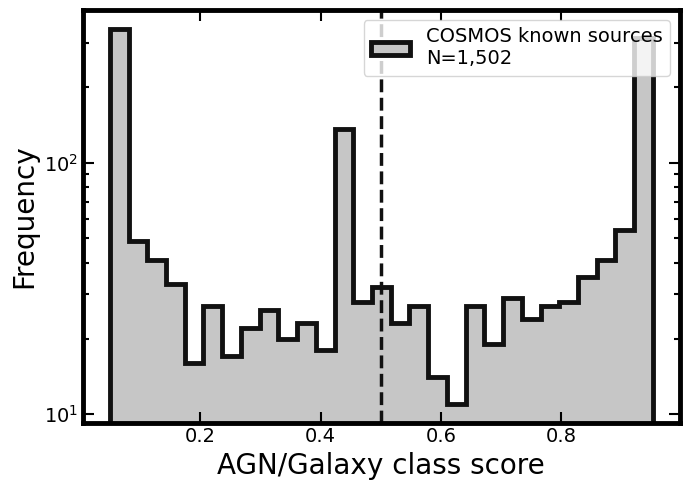

In [72]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(np.isfinite(full_catalog_df.loc[:, 'Score_AGN']))

ax1.hist(full_catalog_df.loc[:, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_AGN_scores_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

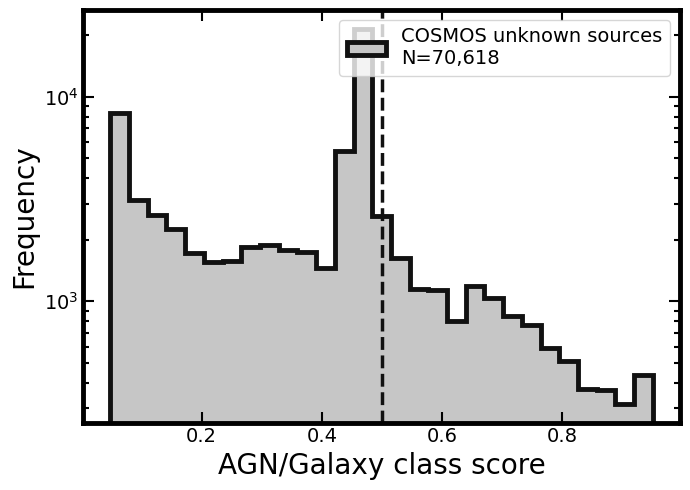

In [73]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[:, 'Score_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[:, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(np.isfinite(unknown_cat_df.loc[:, 'Score_AGN']))

ax1.hist(unknown_cat_df.loc[:, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_AGN_scores_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

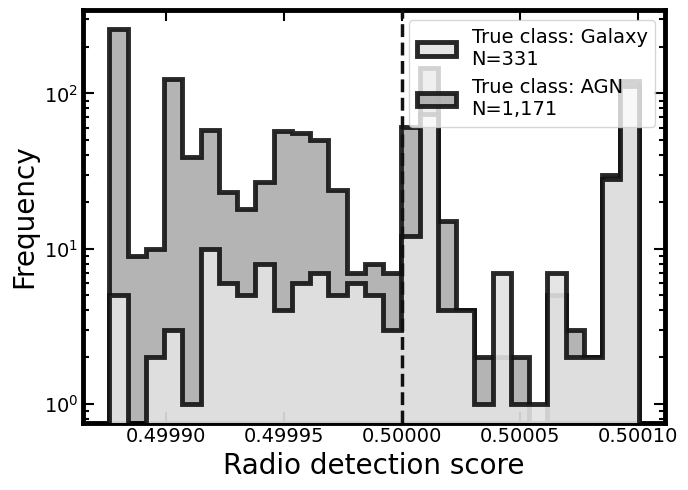

In [74]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_true_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

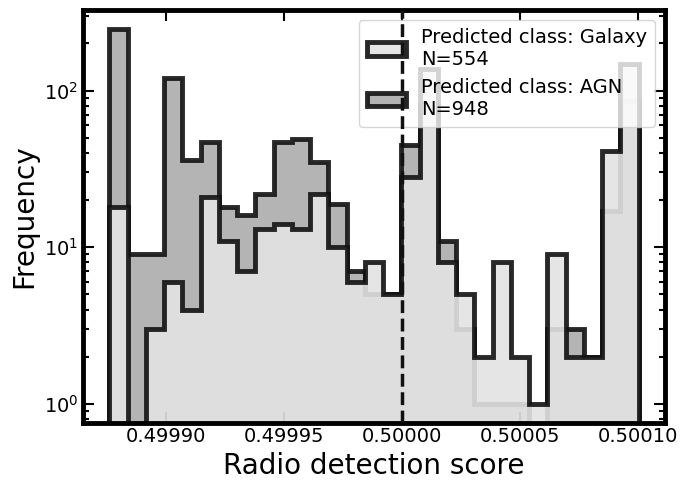

In [75]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=9)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_predicted_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

Plot histograms for predicted and original redshifts.

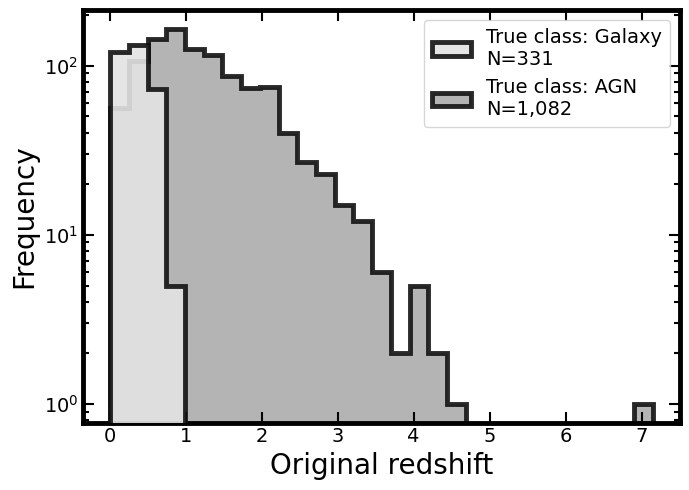

In [76]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_original_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

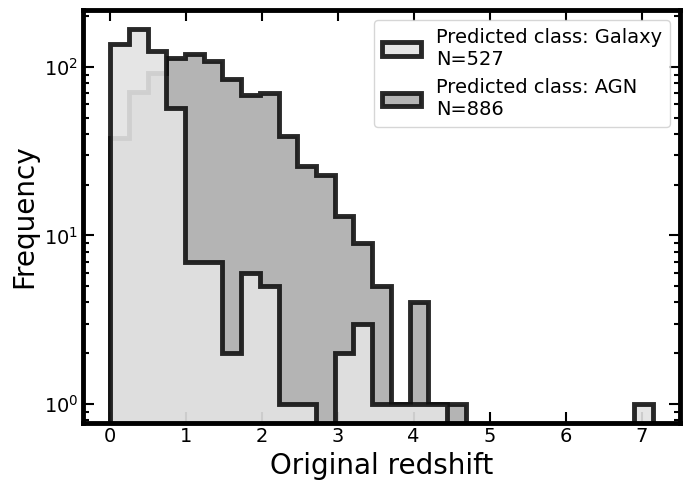

In [77]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <  threshold_AGN), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_true_redshift_predicted_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

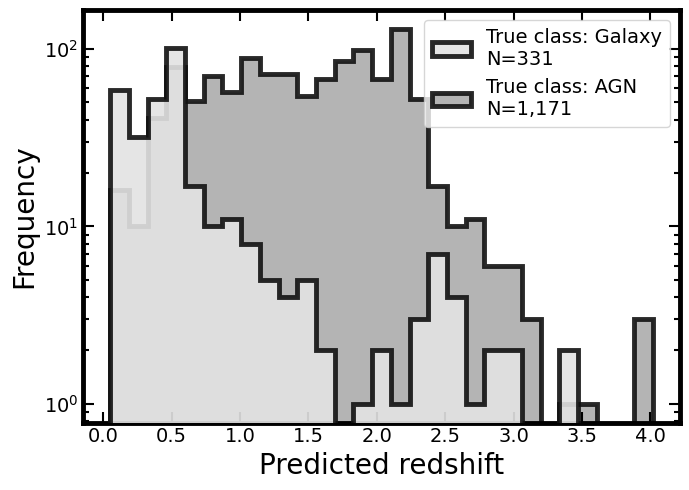

In [78]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Select sources predicted to be Radio AGN

In [80]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
full_catalog_df.loc[filter_radio_AGN_p, displayed_cols].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,284.000000,284.0,284.000000,284.0,264.000000,284.000000
mean,0.989437,1.0,0.732394,1.0,1.030585,1.118887
std,0.102414,0.0,0.443492,0.0,0.662795,0.555237
min,0.000000,1.0,0.000000,1.0,0.044000,0.051400
25%,1.000000,1.0,0.000000,1.0,0.503750,0.686700
50%,1.000000,1.0,1.000000,1.0,0.967000,1.104900
75%,1.000000,1.0,1.000000,1.0,1.380000,1.422450
max,1.000000,1.0,1.000000,1.0,4.183000,2.878700


Add individual metrics for redshift

In [81]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [82]:
str_0_t    = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_t    = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t    = f'{num_str_t:,} are listed as SDSS-DR16 stars and {num_AGN_t:,} are MQC AGN.\n'
str_3_t    = f'Also, {num_radio_AGN_t:,} AGN are detected in radio.'

str_0_p    = f'Out of {num_radio_AGN_t:,} initial radio-detected AGN in {used_area},\n'
str_1_p    = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_p    = f'{num_AGN_p:,} are predicted to be AGN. From the predicted AGN,\n'
str_3_p    = f'{num_radio_AGN_p:,} are predicted to be detected in radio.'

str_0_rAGN = f'{num_radio_AGN_p:,} sources were predicted to be Radio AGN in {used_area}.\n'
str_1_rAGN = f'{num_rAGN_MQC_p:,} of them were listed in MQC.\n'
str_2_rAGN = f'{num_rAGN_gal_p:,} of them are listed as SDSS-DR16 galaxies.\n'
str_3_rAGN = f'{num_rAGN_str_p:,} of them are listed as SDSS-DR16 stars.\n'
str_4_rAGN = f'{num_rAGN_rad_p:,} of them have radio detections.\n'
str_5_rAGN = f'Thus, {num_new_rAGN_p:,} sources are new radio AGN.'

In [83]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)
print(str_0_p + str_1_p + str_2_p + str_3_p)
print('-' * 60)
print(str_0_rAGN + str_1_rAGN + str_2_rAGN + str_3_rAGN + str_4_rAGN + str_5_rAGN)
print('-' * 60)

------------------------------------------------------------
Out of 1,502 initial sources in COSMOS,
331 are confirmed to be galaxies. On the other side,
0 are listed as SDSS-DR16 stars and 1,171 are MQC AGN.
Also, 569 AGN are detected in radio.
------------------------------------------------------------
Out of 569 initial radio-detected AGN in COSMOS,
554 are predicted to be galaxies. On the other side,
948 are predicted to be AGN. From the predicted AGN,
284 are predicted to be detected in radio.
------------------------------------------------------------
284 sources were predicted to be Radio AGN in COSMOS.
281 of them were listed in MQC.
3 of them are listed as SDSS-DR16 galaxies.
0 of them are listed as SDSS-DR16 stars.
208 of them have radio detections.
Thus, -285 sources are new radio AGN.
------------------------------------------------------------


In [84]:
show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN',\
                'radio_detect', 'pred_radio', 'scaled_score_radio', 'scaled_score_rAGN', 'Z', 'pred_Z']

cols_4_table = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'pred_class', 'Score_AGN', 'radio_detect', 'pred_radio', 'Score_radio', 'Score_rAGN', 'Z', 'pred_Z']

In [85]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = show_columns + cols_4_exp_all[used_area] + cols_photo

In [86]:
filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= 3.7

Display properties of newly-predicted Radio AGN.

In [87]:
display(full_catalog_df.loc[filt_new_rAGN_p, cols_4_table].sort_values(by=['pred_Z'], ascending=False).head(20))

,RA_ICRS,DE_ICRS,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,Score_radio,Score_rAGN,Z,pred_Z
59620,149.868469,2.793305,11,1.0,1,0.546007,0,1,0.500010,0.273009,0.300,2.7314
8485,149.641068,2.353417,6,1.0,1,0.453852,0,1,0.500097,0.226970,0.831,2.7080
55882,150.639328,1.883945,11,1.0,1,0.782742,0,1,0.500011,0.391379,0.300,2.4872
48476,149.995285,2.006614,10,1.0,1,0.502460,0,1,0.500010,0.251235,1.033,2.3107
57026,149.744598,2.027437,11,1.0,1,0.950478,0,1,0.500011,0.475250,2.455,2.2677
57303,150.593903,2.801251,15,1.0,1,0.898344,0,1,0.500007,0.449178,2.593,2.1395
55874,150.177826,1.889997,6,1.0,1,0.438331,0,1,0.500097,0.219208,0.864,2.0511
56573,149.416641,2.693603,6,1.0,1,0.383892,0,1,0.500097,0.191983,NaN,2.0511
60464,150.505630,1.542631,6,1.0,1,0.428910,0,1,0.500097,0.214496,2.060,2.0511
41296,149.429260,1.662181,15,1.0,1,0.340878,0,1,0.500011,0.170443,0.844,2.0347


Display properties of old Radio AGN.

In [88]:
display(full_catalog_df.loc[filter_radio_AGN_t, cols_4_table].sort_values(by=['pred_Z'], ascending=False).head(20))

,RA_ICRS,DE_ICRS,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,Score_radio,Score_rAGN,Z,pred_Z
53945,150.476044,2.798354,6,1.0,1,0.414215,1,0,0.499930,0.207079,4.120,3.9677
55838,150.552444,1.796669,7,1.0,1,0.696997,1,0,0.499876,0.348412,NaN,3.5659
56025,150.406586,2.075835,4,1.0,0,0.099327,1,0,0.499905,0.049654,1.257,3.1288
53805,149.870789,2.417337,5,1.0,1,0.578169,1,0,0.499876,0.289013,1.528,2.9308
60160,149.873657,2.467776,7,1.0,1,0.335611,1,1,0.500010,0.167809,0.607,2.8787
27405,150.489761,1.867961,6,1.0,0,0.306565,1,0,0.499928,0.153261,1.264,2.8394
54455,150.608795,2.769750,7,1.0,1,0.947353,1,0,0.499959,0.473637,3.038,2.8274
71384,149.658585,2.984543,10,1.0,1,0.944201,1,0,0.499876,0.471983,2.136,2.7520
48315,150.181412,2.423485,9,1.0,0,0.077793,1,0,0.499922,0.038890,0.727,2.7261
46226,150.381638,2.505726,6,1.0,1,0.518291,1,1,0.500097,0.259196,1.809,2.7073


Display properties of old Radio AGN predicted to be Radio AGN.

In [89]:
display(full_catalog_df.loc[filter_radio_AGN_p * filter_radio_AGN_t, cols_4_table].sort_values(by=['pred_Z'], ascending=False).head(20))

,RA_ICRS,DE_ICRS,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,Score_radio,Score_rAGN,Z,pred_Z
60160,149.873657,2.467776,7,1.0,1,0.335611,1,1,0.500010,0.167809,0.607,2.8787
46226,150.381638,2.505726,6,1.0,1,0.518291,1,1,0.500097,0.259196,1.809,2.7073
55637,149.930893,2.118666,11,1.0,1,0.950344,1,1,0.499979,0.475152,2.210,2.4807
61320,149.552521,2.590802,11,1.0,1,0.692759,1,1,0.499972,0.346360,1.006,2.4660
5489,150.037201,2.244638,11,1.0,1,0.950127,1,1,0.500088,0.475147,2.536,2.3051
56657,150.156906,2.497000,8,1.0,1,0.364220,1,1,0.500088,0.182142,0.671,2.2046
50338,149.837479,1.971906,6,1.0,1,0.434479,1,1,0.500097,0.217282,1.020,2.0511
55579,150.735596,2.199566,10,1.0,1,0.939991,1,1,0.499980,0.469977,3.503,2.0477
5817,150.405106,2.269993,11,1.0,1,0.937710,1,1,0.500004,0.468859,1.638,1.9801
61593,149.784210,1.912742,8,1.0,1,0.534269,1,1,0.500086,0.267181,1.156,1.9307


Display properties of all predicted Radio AGN.

In [90]:
display(full_catalog_df.loc[filt_new_rAGN_p, cols_4_table].sort_values(by=['pred_Z'], ascending=False).head(20))

,RA_ICRS,DE_ICRS,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,Score_radio,Score_rAGN,Z,pred_Z
59620,149.868469,2.793305,11,1.0,1,0.546007,0,1,0.500010,0.273009,0.300,2.7314
8485,149.641068,2.353417,6,1.0,1,0.453852,0,1,0.500097,0.226970,0.831,2.7080
55882,150.639328,1.883945,11,1.0,1,0.782742,0,1,0.500011,0.391379,0.300,2.4872
48476,149.995285,2.006614,10,1.0,1,0.502460,0,1,0.500010,0.251235,1.033,2.3107
57026,149.744598,2.027437,11,1.0,1,0.950478,0,1,0.500011,0.475250,2.455,2.2677
57303,150.593903,2.801251,15,1.0,1,0.898344,0,1,0.500007,0.449178,2.593,2.1395
55874,150.177826,1.889997,6,1.0,1,0.438331,0,1,0.500097,0.219208,0.864,2.0511
56573,149.416641,2.693603,6,1.0,1,0.383892,0,1,0.500097,0.191983,NaN,2.0511
60464,150.505630,1.542631,6,1.0,1,0.428910,0,1,0.500097,0.214496,2.060,2.0511
41296,149.429260,1.662181,15,1.0,1,0.340878,0,1,0.500011,0.170443,0.844,2.0347


Confusion matrix for AGN/galaxy prediction on all sources

In [91]:
MCC_AGN              = MCC_from_CM(cm_AGN)
ACC_AGN              = ACC_from_CM(cm_AGN)
F1_AGN               = F1_from_CM(cm_AGN)
Recall_AGN           = Recall_from_CM(cm_AGN)

Confusion matrices for AGN criteria from literature

In [92]:
MCC_AGN_S12          = MCC_from_CM(cm_AGN_S12)
ACC_AGN_S12          = ACC_from_CM(cm_AGN_S12)
F1_AGN_S12           = F1_from_CM(cm_AGN_S12)
Recall_AGN_S12       = Recall_from_CM(cm_AGN_S12)

MCC_AGN_M12          = MCC_from_CM(cm_AGN_M12)
ACC_AGN_M12          = ACC_from_CM(cm_AGN_M12)
F1_AGN_M12           = F1_from_CM(cm_AGN_M12)
Recall_AGN_M12       = Recall_from_CM(cm_AGN_M12)

MCC_AGN_M16          = MCC_from_CM(cm_AGN_M16)
ACC_AGN_M16          = ACC_from_CM(cm_AGN_M16)
F1_AGN_M16           = F1_from_CM(cm_AGN_M16)
Recall_AGN_M16       = Recall_from_CM(cm_AGN_M16)

MCC_AGN_B18          = MCC_from_CM(cm_AGN_B18)
ACC_AGN_B18          = ACC_from_CM(cm_AGN_B18)
F1_AGN_B18           = F1_from_CM(cm_AGN_B18)
Recall_AGN_B18       = Recall_from_CM(cm_AGN_B18)

Confusion matrix for radio detection prediction on all predicted AGN

In [93]:
MCC_radio            = MCC_from_CM(cm_radio)
ACC_radio            = ACC_from_CM(cm_radio)
F1_radio             = F1_from_CM(cm_radio)
Recall_radio         = Recall_from_CM(cm_radio)

Confusion matrix for radio AGN detection prediction.

In [95]:
MCC_radio_AGN        = MCC_from_CM(cm_rAGN)
ACC_radio_AGN        = ACC_from_CM(cm_rAGN)
F1_radio_AGN         = F1_from_CM(cm_rAGN)
Recall_radio_AGN     = Recall_from_CM(cm_rAGN)

Print metrics

In [97]:
print('Metrics for AGN prediction on all spectroscopically confirmed sources.')
print(f'Sample size,                        N = {np.sum(filter_known_spec):,}')
print(f'F-1 Score,                         F1 = {F1_AGN:.4f}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_AGN:.4f}')

Metrics for AGN prediction on all spectroscopically confirmed sources.
Sample size,                        N = 1,502
F-1 Score,                         F1 = 0.8882
Matthews Correlation Coefficient, MCC = 0.6722
Recall,                        Recall = 0.8036
Accuracy,                         ACC = 0.8422


In [98]:
print('Metrics for AGN detection criteria (from literature) on all spectroscopically confirmed sources.')
print(f'Sample size, N = {np.sum(filter_known_spec):,}')
print('Criterion:        S12\tM12\tM16\tB18')
print(f'F-1 Score,  F1 = {F1_AGN_S12:.4f}\t{F1_AGN_M12:.4f}\t{F1_AGN_M16:.4f}\t{F1_AGN_B18:.4f}')
print(f'MCC,       MCC = {MCC_AGN_S12:.4f}\t{MCC_AGN_M12:.4f}\t{MCC_AGN_M16:.4f}\t{MCC_AGN_B18:.4f}')
print(f'Recall, Recall = {Recall_AGN_S12:.4f}\t{Recall_AGN_M12:.4f}\t{Recall_AGN_M16:.4f}\t{Recall_AGN_B18:.4f}')
print(f'Accuracy,  ACC = {ACC_AGN_S12:.4f}\t{ACC_AGN_M12:.4f}\t{ACC_AGN_M16:.4f}\t{ACC_AGN_B18:.4f}')

Metrics for AGN detection criteria (from literature) on all spectroscopically confirmed sources.
Sample size, N = 1,502
Criterion:        S12	M12	M16	B18
F-1 Score,  F1 = 0.7030	0.2455	0.4172	0.5617
MCC,       MCC = 0.4411	0.1816	0.2542	0.3328
Recall, Recall = 0.5448	0.1401	0.2647	0.3928
Accuracy,  ACC = 0.6411	0.3289	0.4234	0.5220


In [99]:
print('Metrics for radio detection prediction on all predicted AGN')
print(f'Sample size,                        N = {np.sum(filter_AGN_p):,}')
print(f'F-1 Score,                         F1 = {F1_radio:.4f}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio:.4f}')
print(f'Recall,                        Recall = {Recall_radio:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio:.4f}')

Metrics for radio detection prediction on all predicted AGN
Sample size,                        N = 948
F-1 Score,                         F1 = 0.5738
Matthews Correlation Coefficient, MCC = 0.3504
Recall,                        Recall = 0.4717
Accuracy,                         ACC = 0.6741


In [101]:
print('Metrics for radio AGN detection prediction')
print(f'Sample size,                        N = {total_size:,}')
print(f'F-1 Score,                         F1 = {F1_radio_AGN:.4f}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_radio_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_AGN:.4f}')

Metrics for radio AGN detection prediction
Sample size,                        N = 1,502
F-1 Score,                         F1 = 0.4830
Matthews Correlation Coefficient, MCC = 0.3449
Recall,                        Recall = 0.3620
Accuracy,                         ACC = 0.7064


In [103]:
print('Metrics for redshift prediction on all predicted radio AGN with only one Z model')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"])):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_early:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_early:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_early:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_early:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_early:.4f}')

Metrics for redshift prediction on all predicted radio AGN with only one Z model
Sample size,                        N = 1,413
Sigma MAD                       σ MAD = 0.2829
Sigma NMAD,                    σ NMAD = 0.1428
Sigma z,                          σ z = 0.5714
Sigma z normalized,             σ z N = 0.3078
Outlier fraction,                   η = 0.3750


In [104]:
print('Metrics for redshift prediction on all predicted radio AGN with all models')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"])):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_field:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_field:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_field:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_field:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_field:.4f}')

Metrics for redshift prediction on all predicted radio AGN with all models
Sample size,                        N = 1,413
Sigma MAD                       σ MAD = 0.2829
Sigma NMAD,                    σ NMAD = 0.1428
Sigma z,                          σ z = 0.5714
Sigma z normalized,             σ z N = 0.3078
Outlier fraction,                   η = 0.3750


In [105]:
print('Metrics for redshift prediction on predicted radio AGN with only one Z model at high z (original prediction)')
samp_size_tmp  = np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"]) &\
                        np.array(full_catalog_df.loc[:, "pred_Z"] >= redshift_lim_c))
print(f'Sample size,                        N = {samp_size_tmp:,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_early_hiz:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_early_hiz:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_early_hiz:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_early_hiz:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_early_hiz:.4f}')

Metrics for redshift prediction on predicted radio AGN with only one Z model at high z (original prediction)
Sample size,                        N = 2
Sigma MAD                       σ MAD = nan
Sigma NMAD,                    σ NMAD = nan
Sigma z,                          σ z = nan
Sigma z normalized,             σ z N = nan
Outlier fraction,                   η = nan


In [106]:
print('Metrics for redshift prediction on predicted radio AGN with all models at high z')
samp_size_tmp  = np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"]) &\
                        np.array(full_catalog_df.loc[:, "pred_Z"] >= redshift_lim_c))
print(f'Sample size,                        N = {samp_size_tmp:,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_field_hiz:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_field_hiz:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_field_hiz:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_field_hiz:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_field_hiz:.4f}')

Metrics for redshift prediction on predicted radio AGN with all models at high z
Sample size,                        N = 2
Sigma MAD                       σ MAD = nan
Sigma NMAD,                    σ NMAD = nan
Sigma z,                          σ z = nan
Sigma z normalized,             σ z N = nan
Outlier fraction,                   η = nan


Plot predictions

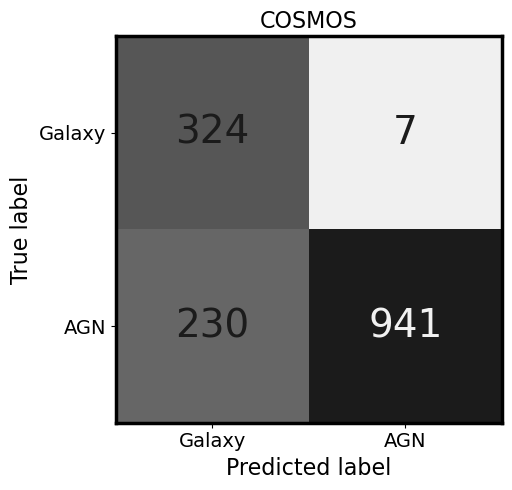

In [107]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

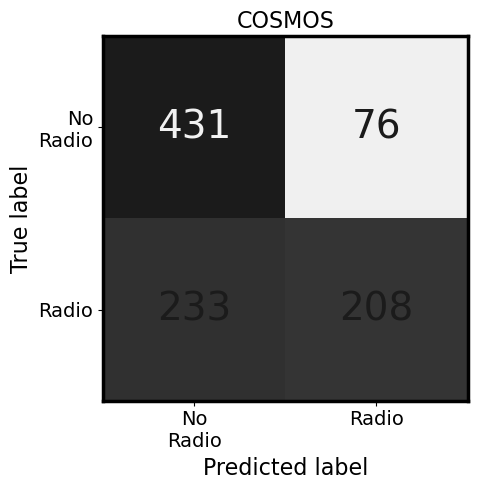

In [108]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

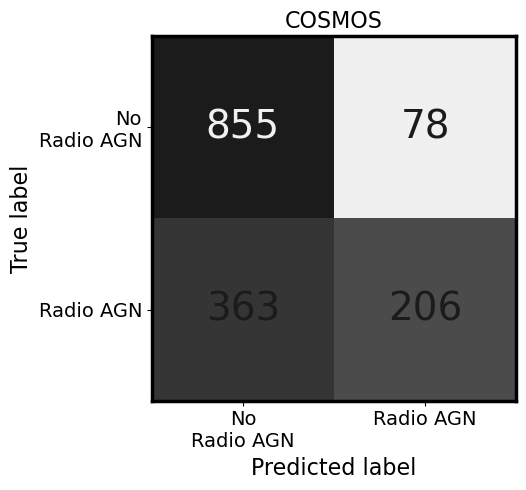

In [109]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_rAGN, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

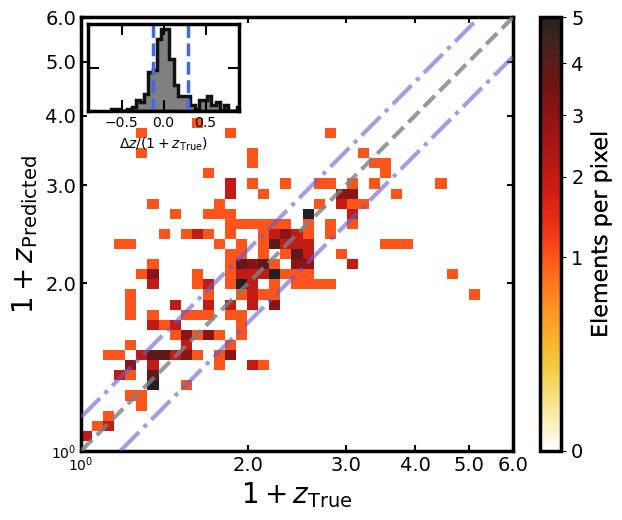

In [110]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)

if save_plot_flag:
    plt.savefig(f'plots/compare_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

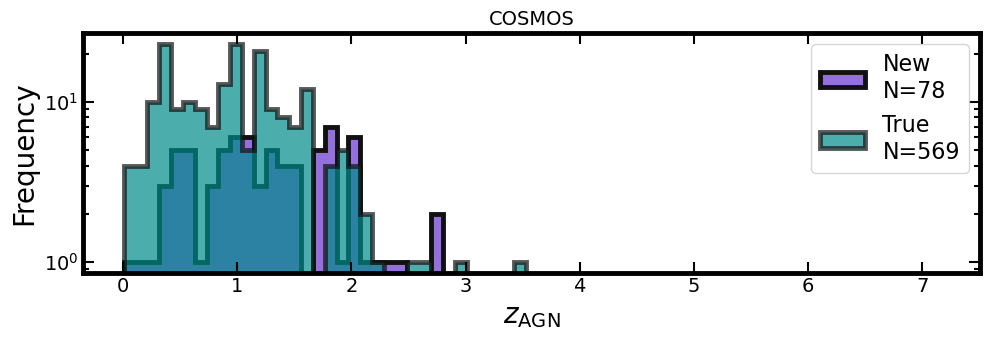

In [111]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(full_catalog_df.loc[:, 'Z']),\
                           np.nanmin(full_catalog_df.loc[:, 'pred_Z'])])
max_for_range = np.nanmax([np.nanmax(full_catalog_df.loc[:, 'Z']),\
                           np.nanmax(full_catalog_df.loc[:, 'pred_Z'])])
bins_z        = np.linspace(min_for_range, max_for_range, 70)



_, bins, _ = ax1.hist(full_catalog_df.loc[filt_new_rAGN_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"New\nN={np.sum(filt_new_rAGN_p):,}")
ax1.hist(full_catalog_df.loc[filter_radio_AGN_t * filter_radio_AGN_p, 'Z'], bins=bins_z, histtype='stepfilled', ec='k',\
         fc='darkcyan', lw=3.5, label=f"True\nN={np.sum(filter_radio_AGN_t):,}", alpha=0.7)

# ax1.axvline(x=3.6, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=3.7, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=3.8, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=3.9, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=4.0, ls='--', c='k', lw=2.5, zorder=10)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_true_predicted_z_{used_area}.pdf')
plt.show()

---

## Additional test with data from Ananna et al., 2017

In [112]:
if compare_A17_flag:
    full_catalog_A17_df = pd.read_hdf(cat_path + file_S82_Ananna_17, key='df').drop(columns=features_2_discard)

In [113]:
if compare_A17_flag:
    full_catalog_A17_df = pyr.predict_model(redshift_reg, data=full_catalog_A17_df, round=8)
    full_catalog_A17_df = full_catalog_A17_df.rename(columns={'Label': 'pred_Z', 'is_AGN': 'class'})
    full_catalog_A17_df['pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    redshift_lim_0    = 2.0
    redshift_tol_0    = 0.0
    redshift_lim_1    = 3.0
    redshift_tol_1    = 0.0
    redshift_lim_2    = 3.6
    redshift_tol_2    = 0.0
    if use_second_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_2, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_0 + redshift_tol_0)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    if use_third_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_3, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_1 + redshift_tol_1)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    if use_fourth_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_4, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_2 + redshift_tol_2)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)

In [114]:
if compare_A17_flag:
    sigma_mad_AGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_AGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_AGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_AGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_AGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [115]:
if compare_A17_flag:
    print('Metrics for redshift prediction on AGN from Ananna et al., 2017')
    print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"])):,}')
    print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_AGN_A17:.4f}')
    print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_AGN_A17:.4f}')
    print(f'Sigma z,                          \u03C3 z = {sigma_z_AGN_A17:.4f}')
    print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_AGN_A17:.4f}')
    print(f'Outlier fraction,                   \u03B7 = {out_frac_AGN_A17:.4f}')

In [116]:
if compare_A17_flag:
    fig              = plt.figure(figsize=(7.5,4.3))
    ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
    
    min_score        = np.nanmin([np.nanmin(full_catalog_A17_df.loc[:, 'zsp']), np.nanmin(full_catalog_A17_df.loc[:, 'pred_Z'])])
    max_score        = np.nanmax([np.nanmax(full_catalog_A17_df.loc[:, 'zsp']), np.nanmax(full_catalog_A17_df.loc[:, 'pred_Z'])])
    score_bins       = np.linspace(min_score, max_score, 30)
    
    sample_size_orig = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']))
    sample_size_pred = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    
    ax1.hist(full_catalog_A17_df.loc[:, 'zsp'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
             label=f'Original\nN={sample_size_orig:,}', zorder=2)
    ax1.hist(full_catalog_A17_df.loc[:, 'pred_Z'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.7,\
             label=f'Predicted\nN={sample_size_pred:,}', zorder=1)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    ax1.set_title('S82: Ananna+17')
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/hist_redshift_AGN_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()

In [117]:
if compare_A17_flag:
    full_catalog_A17_df = full_catalog_A17_df.loc[np.array(full_catalog_A17_df.loc[:, 'class'] == 1) &\
                                                  np.array(full_catalog_A17_df.loc[:, 'radio_detect'] == 1)]

In [118]:
if compare_A17_flag:
    used_z_col = 'zsp'
    full_catalog_A17_df['Delta_z_N'] = np.around((full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                 (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)
    full_catalog_A17_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                  (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)

In [119]:
if compare_A17_flag:
    show_columns_A17 = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'class', 'radio_detect', 'Z', 'zsp', 'pred_Z', 'Delta_z_N']
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by='pred_Z', ascending=False).head(10))
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by=used_z_col, ascending=False).head(10))

In [120]:
if compare_A17_flag:
    sigma_mad_rAGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_rAGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_rAGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_rAGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_rAGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [121]:
if compare_A17_flag:
    print('Metrics for redshift prediction on radio AGN from Ananna et al., 2017')
    print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"])):,}')
    print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_rAGN_A17:.4f}')
    print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_rAGN_A17:.4f}')
    print(f'Sigma z,                          \u03C3 z = {sigma_z_rAGN_A17:.4f}')
    print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_rAGN_A17:.4f}')
    print(f'Outlier fraction,                   \u03B7 = {out_frac_rAGN_A17:.4f}')

In [122]:
if compare_A17_flag:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    plot_redshift_compare(full_catalog_A17_df.loc[:, used_z_col], full_catalog_A17_df.loc[:, 'pred_Z'],\
                          ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    if save_plot_flag:
        plt.savefig(f'plots/compare_redshift_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()